In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import corner
import warnings; warnings.simplefilter('ignore')
from scipy.stats import norm

In [2]:
def model(t_data,par):
    A=par[0]
    B=par[1]
    t_0=par[2]
    a=par[3]
    if t_data < t_0:
        y=B
    if t_data >= t_0:
        y=B+A*np.exp(-a*(t_data-t_0))
    return y


def log_likelihood(par,t_data,y_data,err_data):
    log_likelihoods=np.array([(-(y_data[i]-model(t_data[i],par))**2/(2*err_data[i]**2)) for i in range(0,len(t_data))])
    return np.sum(log_likelihoods)

def log_prior(A,B,t0,a):
    t0_min,t0_max = 0,100
    A_min,A_max=0,50
    B_min,B_max=0,50
    a_min,a_max=np.exp(-5),np.exp(5)
    if (A_min<A<A_max and B_min<B<B_max and t0_min<t0<t0_max and a_min<a<a_max):
        return np.log(1/100)+np.log(1/50)+np.log(1/50)-np.log(a)
    return -np.inf
    #p_A=1/2
    #p_B=1/2
    #p_t_0=1/5
    #p_a=1
    #return np.log(p_A*p_B*p_t_0*p_a) 

def log_Posterior(par,t_data,y_data,err_data):
    return log_likelihood(par,t_data,y_data,err_data)+log_prior(par[0],par[1],par[2],par[3])

<ErrorbarContainer object of 3 artists>

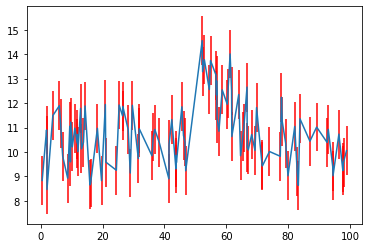

In [3]:
#loading data

data=np.load('transient.npy')
t_data=data[:,0]
y_data=data[:,1]
err_data=data[:,2]

#plotting

plt.errorbar(data[:,0],data[:,1],data[:,2],ecolor='red')

In [4]:
ndim = 4  # number of parameters in the model
nwalkers = 8  # number of MCMC walkers
nsteps = 10000  # number of MCMC steps to take **for each walker**


#making the initial guesses

guess=[5,10,50,0.1]
guesses=[]
for i in range(nwalkers):
    
    #choosing guess by sampling a normal distribution for each parameter
    
    guesses.append(np.array([norm(g,0.05).rvs(1) for g in guess]))
starting_guesses=np.reshape(guesses,[nwalkers,ndim])

#MCMC sampler 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_Posterior, args=[t_data,y_data,err_data])
sampler.run_mcmc(starting_guesses, nsteps)

print("done")

done


In [5]:
#printing autocorrelation times

tau = sampler.get_autocorr_time()
print(tau)

[ 94.87344433  73.30904491 102.61649044  66.19074647]


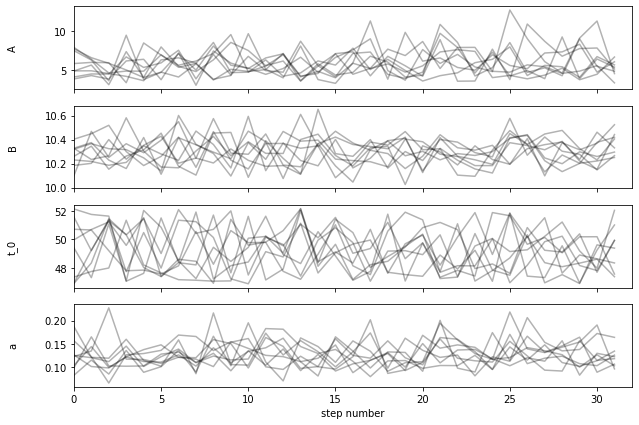

In [7]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)

#autocorrelation time for each parameter

tau = sampler.get_autocorr_time()

#using data taking into account the autocorrelation length

samples = sampler.get_chain(discard=2*int(np.max(tau)), thin=3*int(np.max(tau)))

#defining labels

labels = ["A","B","t_0","a"]

#plotting traceplots

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

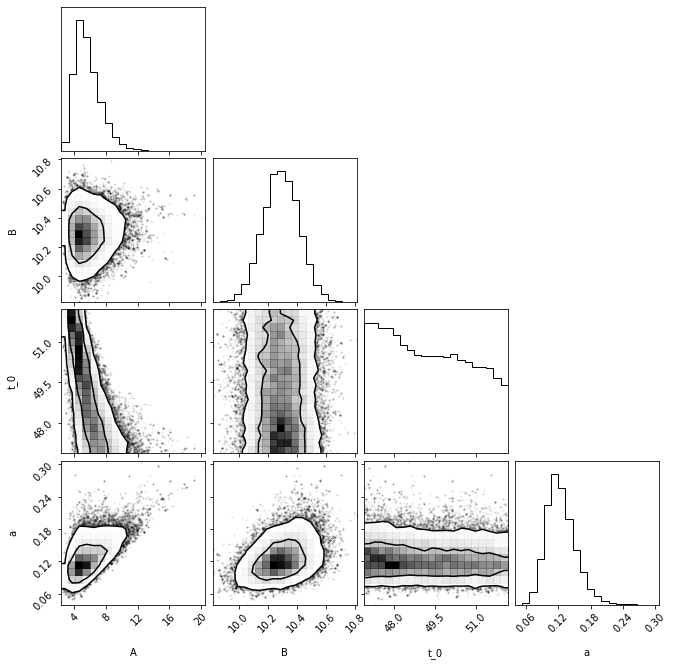

In [8]:
#creating vectors with the chains

flat_chain=sampler.get_chain(flat=True)

#plotting a corner plot

corner.corner(flat_chain, labels=labels, levels=[0.68,0.95]);

Text(0.5, 1.0, 'Model comparison plots')

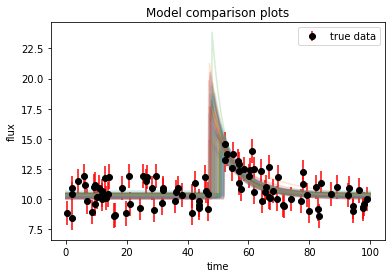

In [9]:
#choosing some random parameters to plot the results

random_indeces=np.random.randint(0,len(flat_chain[:,0]),100)


A=np.array([flat_chain[i,0] for i in random_indeces ])
B=np.array([flat_chain[i,1] for i in random_indeces ])
t0=np.array([flat_chain[i,2] for i in random_indeces ])
a=np.array([flat_chain[i,3] for i in random_indeces])

#creating parameters vector

pars=np.stack((A,B,t0,a),axis=1)

#defining a grid

xgrid=np.linspace(0,100,1000)

#plotting the result for each set of parameters

for par in pars:
    y=np.array([model(x,par) for x in xgrid])
    plt.plot(xgrid,y,alpha=0.2)
    
#plotting real data

plt.errorbar(data[:,0],data[:,1],data[:,2],color='black',fmt="o",ecolor='red',label='true data')
plt.legend()
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Model comparison plots')

Best parameter:  5.370888576031394 + 3.4331247878371407 - 1.7663235161299227


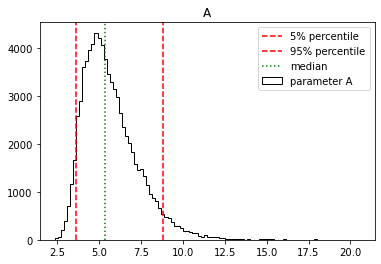

Best parameter:  10.28804164173098 + 0.20278147853968598 - 0.20078144567314027


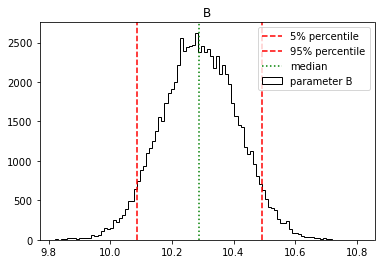

Best parameter:  49.17789262731955 + 2.6266188695378645 - 2.1060647126254963


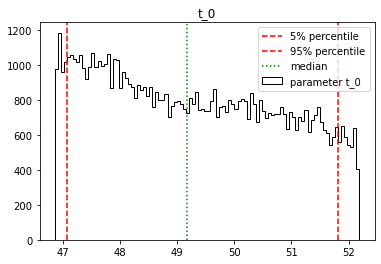

Best parameter:  0.12142031308964057 + 0.0520743491548839 - 0.03528180326783749


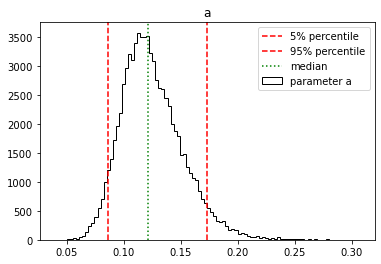

In [14]:
lables=['A','B','t0','a']

#finding 90% credible region

for i in range(4):
    plt.hist(flat_chain[:,i],bins=100,color='black',histtype='step',label='parameter '+labels[i]);
    plt.axvline(np.percentile(flat_chain[:,i],5),color='red',linestyle='--',label='5% percentile')
    plt.axvline(np.percentile(flat_chain[:,i],95),color='red',linestyle='--',label='95% percentile')
    plt.axvline(np.median(flat_chain[:,i]),color='green',linestyle=':',label='median')
    print('Best parameter: ', np.median(flat_chain[:,i]),r'+',-np.median(flat_chain[:,i])+np.percentile(flat_chain[:,i],95),'-',np.median(flat_chain[:,i])-np.percentile(flat_chain[:,i],5))
    plt.title(labels[i])
    plt.legend()
    plt.show()

    

Text(0.5, 1.0, 'Best model')

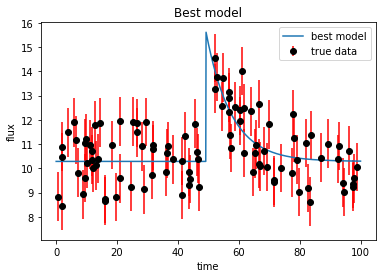

In [13]:
#Computing the best model

best_params=np.array([np.median(flat_chain[:,i]) for i in range(4)])
xgrid=np.linspace(0,100,1000)
y=np.array([model(x,best_params) for x in xgrid])

#plotting

plt.plot(xgrid,y,label='best model')
plt.errorbar(data[:,0],data[:,1],data[:,2],color='black',fmt="o",ecolor='red',label='true data')
plt.legend()
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Best model')